In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.get_logger().setLevel('ERROR')

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import load_mnist, preprocess, to_categorical
from art.defences.trainer import AdversarialTrainerMadryPGD


from art.estimators.classification.deep_partition_ensemble import DeepPartitionEnsemble

# Load the Data

In [2]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 10000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

# Poison training data
percent_poison = .33
x_train, y_train = preprocess(x_raw, y_raw)
x_train = np.expand_dims(x_train, axis=3)

x_test, y_test = preprocess(x_raw_test, y_raw_test)
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

# Initialize the Model Architecture

In [3]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
def create_model():    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Set up the Model Backdoor

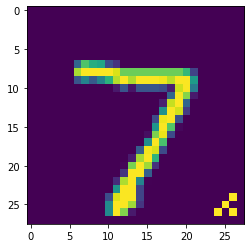

In [4]:
backdoor = PoisoningAttackBackdoor(add_pattern_bd)
example_target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
pdata, plabels = backdoor.poison(x_test, y=example_target)

plt.imshow(pdata[0].squeeze())

# Create the poison data
For this example, we will select 9 as the target class. Thus, the adversary's goal is to poison the model so adding a trigger will result in the trained model misclassifying the triggered input as a 9.

First, the adversary will create a proxy classifier (i.e., a classifier that is similar to the target classifier). As the clean label attack generates noise using PGD in order to encourage the trained classifier to rely on the trigger, it is important that the generated noise be transferable. Thus, adversarial training is used.

In [5]:
# Poison some percentage of all non-nines to nines
targets = to_categorical([9], 10)[0] 

proxy = AdversarialTrainerMadryPGD(KerasClassifier(create_model()), nb_epochs=10, eps=0.15, eps_step=0.001)
proxy.fit(x_train, y_train)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
attack = PoisoningAttackCleanLabelBackdoor(backdoor=backdoor, proxy_classifier=proxy.get_classifier(),
                                           target=targets, pp_poison=percent_poison, norm=2, eps=5,
                                           eps_step=0.1, max_iter=200)
pdata, plabels = attack.poison(x_train, y_train)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

1031


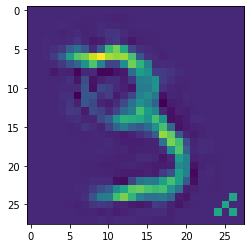

Index: 121 Label: 9


In [7]:
poisoned = pdata[np.all(plabels == targets, axis=1)]
poisoned_labels = plabels[np.all(plabels == targets, axis=1)]
print(len(poisoned))
for i in range(len(poisoned)):
    if poisoned[i][0][0] != 0:
        plt.imshow(poisoned[i].squeeze())
        plt.show()
        print(f"Index: {i} Label: {np.argmax(poisoned_labels[i])}")
        break

# Initialize the classification models
We will initialize four models. The first is a single model architecture. The other three are DPA models with varying ensemble sizes to demonstrate the tradeoff between clean accuracy and poison accuracy. This make take some time because of the model copying.

In [8]:
model = KerasClassifier(create_model())
dpa_model_10 = DeepPartitionEnsemble(model, ensemble_size=10)
dpa_model_20 = DeepPartitionEnsemble(model, ensemble_size=20)
dpa_model_30 = DeepPartitionEnsemble(model, ensemble_size=30)


Train the models on the poisoned data

In [9]:
model.fit(pdata, plabels, nb_epochs=10)
dpa_model_10.fit(pdata, plabels, nb_epochs=10)
dpa_model_20.fit(pdata, plabels, nb_epochs=10)
dpa_model_30.fit(pdata, plabels, nb_epochs=10)

Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 1s 108us/sample - loss: 0.7052 - accuracy: 0.7729
Epoch 2/10
10000/10000 [==============================] - 1s 54us/sample - loss: 0.2429 - accuracy: 0.9269
Epoch 3/10
10000/10000 [==============================] - 1s 54us/sample - loss: 0.1475 - accuracy: 0.9547
Epoch 4/10
10000/10000 [==============================] - 1s 55us/sample - loss: 0.1066 - accuracy: 0.9669
Epoch 5/10
10000/10000 [==============================] - 1s 54us/sample - loss: 0.0929 - accuracy: 0.9709
Epoch 6/10
10000/10000 [==============================] - 1s 57us/sample - loss: 0.0735 - accuracy: 0.9770
Epoch 7/10
10000/10000 [==============================] - 1s 56us/sample - loss: 0.0649 - accuracy: 0.9794
Epoch 8/10
10000/10000 [==============================] - 1s 53us/sample - loss: 0.0532 - accuracy: 0.9829
Epoch 9/10
10000/10000 [==============================] - 1s 54us/sample - loss: 0.0519 - accuracy: 0.9819
Epoch 10/10
1

965/965 [==============================] - 0s 55us/sample - loss: 0.3130 - accuracy: 0.9047
Epoch 8/10
965/965 [==============================] - 0s 56us/sample - loss: 0.2506 - accuracy: 0.9140
Epoch 9/10
965/965 [==============================] - 0s 56us/sample - loss: 0.2010 - accuracy: 0.9337
Epoch 10/10
965/965 [==============================] - 0s 56us/sample - loss: 0.1788 - accuracy: 0.9430
Train on 960 samples
Epoch 1/10
960/960 [==============================] - 10s 10ms/sample - loss: 1.9319 - accuracy: 0.3490
Epoch 2/10
960/960 [==============================] - 0s 58us/sample - loss: 1.0600 - accuracy: 0.6562
Epoch 3/10
960/960 [==============================] - 0s 70us/sample - loss: 0.7355 - accuracy: 0.7615
Epoch 4/10
960/960 [==============================] - 0s 56us/sample - loss: 0.6186 - accuracy: 0.7958
Epoch 5/10
960/960 [==============================] - 0s 56us/sample - loss: 0.4318 - accuracy: 0.8667
Epoch 6/10
960/960 [==============================] - 0s 57us

504/504 [==============================] - 0s 57us/sample - loss: 0.7496 - accuracy: 0.7480
Epoch 5/10
504/504 [==============================] - 0s 58us/sample - loss: 0.5711 - accuracy: 0.8155
Epoch 6/10
504/504 [==============================] - 0s 64us/sample - loss: 0.5004 - accuracy: 0.8274
Epoch 7/10
504/504 [==============================] - 0s 63us/sample - loss: 0.3938 - accuracy: 0.8730
Epoch 8/10
504/504 [==============================] - 0s 57us/sample - loss: 0.3602 - accuracy: 0.8929
Epoch 9/10
504/504 [==============================] - 0s 55us/sample - loss: 0.3372 - accuracy: 0.8869
Epoch 10/10
504/504 [==============================] - 0s 56us/sample - loss: 0.3048 - accuracy: 0.9048
Train on 531 samples
Epoch 1/10
531/531 [==============================] - 10s 20ms/sample - loss: 2.1457 - accuracy: 0.2655
Epoch 2/10
531/531 [==============================] - 0s 63us/sample - loss: 1.4525 - accuracy: 0.5669
Epoch 3/10
531/531 [==============================] - 0s 61us

514/514 [==============================] - 11s 21ms/sample - loss: 2.1577 - accuracy: 0.2588
Epoch 2/10
514/514 [==============================] - 0s 67us/sample - loss: 1.5944 - accuracy: 0.4611
Epoch 3/10
514/514 [==============================] - 0s 64us/sample - loss: 1.0789 - accuracy: 0.6946
Epoch 4/10
514/514 [==============================] - 0s 62us/sample - loss: 0.8286 - accuracy: 0.7257
Epoch 5/10
514/514 [==============================] - 0s 63us/sample - loss: 0.7126 - accuracy: 0.7763
Epoch 6/10
514/514 [==============================] - 0s 63us/sample - loss: 0.6088 - accuracy: 0.8074
Epoch 7/10
514/514 [==============================] - 0s 63us/sample - loss: 0.5985 - accuracy: 0.8132
Epoch 8/10
514/514 [==============================] - 0s 62us/sample - loss: 0.5741 - accuracy: 0.8307
Epoch 9/10
514/514 [==============================] - 0s 63us/sample - loss: 0.4387 - accuracy: 0.8638
Epoch 10/10
514/514 [==============================] - 0s 63us/sample - loss: 0.392

508/508 [==============================] - 0s 57us/sample - loss: 0.3650 - accuracy: 0.8937
Epoch 10/10
508/508 [==============================] - 0s 59us/sample - loss: 0.2870 - accuracy: 0.9016
Train on 334 samples
Epoch 1/10
334/334 [==============================] - 11s 34ms/sample - loss: 2.2304 - accuracy: 0.2126
Epoch 2/10
334/334 [==============================] - 0s 67us/sample - loss: 1.7987 - accuracy: 0.4222
Epoch 3/10
334/334 [==============================] - 0s 61us/sample - loss: 1.3135 - accuracy: 0.5958
Epoch 4/10
334/334 [==============================] - 0s 64us/sample - loss: 0.9888 - accuracy: 0.7066
Epoch 5/10
334/334 [==============================] - 0s 70us/sample - loss: 0.7812 - accuracy: 0.7485
Epoch 6/10
334/334 [==============================] - 0s 63us/sample - loss: 0.6072 - accuracy: 0.8084
Epoch 7/10
334/334 [==============================] - 0s 74us/sample - loss: 0.5317 - accuracy: 0.8413
Epoch 8/10
334/334 [==============================] - 0s 64us

302/302 [==============================] - 0s 66us/sample - loss: 0.7800 - accuracy: 0.7417
Epoch 7/10
302/302 [==============================] - 0s 65us/sample - loss: 0.6380 - accuracy: 0.8046
Epoch 8/10
302/302 [==============================] - 0s 66us/sample - loss: 0.6461 - accuracy: 0.7848
Epoch 9/10
302/302 [==============================] - 0s 66us/sample - loss: 0.5215 - accuracy: 0.8344
Epoch 10/10
302/302 [==============================] - 0s 66us/sample - loss: 0.4307 - accuracy: 0.8642
Train on 373 samples
Epoch 1/10
373/373 [==============================] - 12s 32ms/sample - loss: 2.2136 - accuracy: 0.2225
Epoch 2/10
373/373 [==============================] - 0s 64us/sample - loss: 1.8037 - accuracy: 0.4477
Epoch 3/10
373/373 [==============================] - 0s 61us/sample - loss: 1.3851 - accuracy: 0.5952
Epoch 4/10
373/373 [==============================] - 0s 61us/sample - loss: 0.9929 - accuracy: 0.6622
Epoch 5/10
373/373 [==============================] - 0s 59us

328/328 [==============================] - 0s 65us/sample - loss: 1.3353 - accuracy: 0.6341
Epoch 4/10
328/328 [==============================] - 0s 64us/sample - loss: 1.0507 - accuracy: 0.6677
Epoch 5/10
328/328 [==============================] - 0s 63us/sample - loss: 0.8383 - accuracy: 0.7500
Epoch 6/10
328/328 [==============================] - 0s 65us/sample - loss: 0.7312 - accuracy: 0.7652
Epoch 7/10
328/328 [==============================] - 0s 66us/sample - loss: 0.6822 - accuracy: 0.7774
Epoch 8/10
328/328 [==============================] - 0s 64us/sample - loss: 0.5348 - accuracy: 0.8201
Epoch 9/10
328/328 [==============================] - 0s 61us/sample - loss: 0.4700 - accuracy: 0.8445
Epoch 10/10
328/328 [==============================] - 0s 61us/sample - loss: 0.4128 - accuracy: 0.8628
Train on 322 samples
Epoch 1/10
322/322 [==============================] - 12s 39ms/sample - loss: 2.2272 - accuracy: 0.1925
Epoch 2/10
322/322 [==============================] - 0s 86us

Epoch 1/10
364/364 [==============================] - 1s 2ms/sample - loss: 2.2163 - accuracy: 0.1978
Epoch 2/10
364/364 [==============================] - 0s 64us/sample - loss: 1.7952 - accuracy: 0.5000
Epoch 3/10
364/364 [==============================] - 0s 62us/sample - loss: 1.2267 - accuracy: 0.6566
Epoch 4/10
364/364 [==============================] - 0s 62us/sample - loss: 0.8932 - accuracy: 0.7198
Epoch 5/10
364/364 [==============================] - 0s 61us/sample - loss: 0.7026 - accuracy: 0.7473
Epoch 6/10
364/364 [==============================] - 0s 61us/sample - loss: 0.5699 - accuracy: 0.8104
Epoch 7/10
364/364 [==============================] - 0s 62us/sample - loss: 0.4666 - accuracy: 0.8379
Epoch 8/10
364/364 [==============================] - 0s 62us/sample - loss: 0.3683 - accuracy: 0.8791
Epoch 9/10
364/364 [==============================] - 0s 61us/sample - loss: 0.3244 - accuracy: 0.8901
Epoch 10/10
364/364 [==============================] - 0s 61us/sample - lo

# Evaluate the performance of the trained models on unpoisoned data
The performance of the models appears normal. We see that for the DPA models, the performance drops slightly as the ensemble size increases


Clean test set accuracy (model): 98.26%


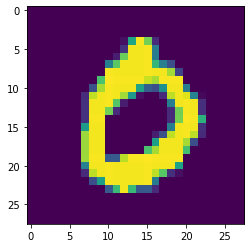

Prediction: 0


In [10]:
clean_preds = np.argmax(model.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (model): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))


Clean test set accuracy (DPA model_10): 93.85%


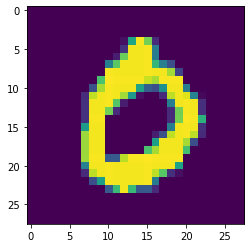

Prediction: 0


In [11]:
clean_preds = np.argmax(dpa_model_10.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (DPA model_10): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))


Clean test set accuracy (DPA model_20): 91.04%


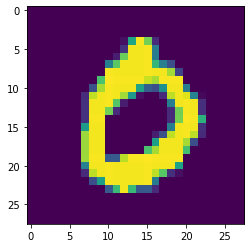

Prediction: 0


In [12]:
clean_preds = np.argmax(dpa_model_20.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (DPA model_20): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))


Clean test set accuracy (DPA model_30): 89.10%


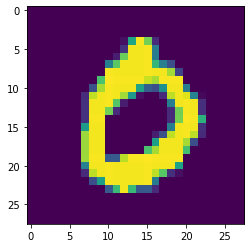

Prediction: 0


In [13]:
clean_preds = np.argmax(dpa_model_30.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (DPA model_30): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

# Evaluate the performance of the trained models on poisoned data
When the trigger is added, we see a shift in performance. The single model performs the worst as no defense is in place to mitigate the effect of the poisoned. The DPA models show some robustnesss to the poison as they partition the training data, which spreads the effect of the poison between models in the ensemble.


Poison test set accuracy (model): 0.79%


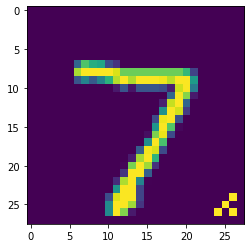

Prediction: 9


In [14]:
not_target = np.logical_not(np.all(y_test == targets, axis=1))
px_test, py_test = backdoor.poison(x_test[not_target], y_test[not_target])

poison_preds = np.argmax(model.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (model): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))


Poison test set accuracy (DPA model_10): 66.82%


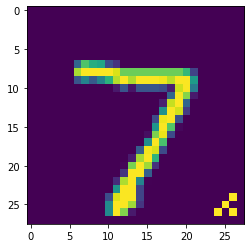

Prediction: 7


In [15]:
poison_preds = np.argmax(dpa_model_10.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (DPA model_10): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))


Poison test set accuracy (DPA model_20): 75.28%


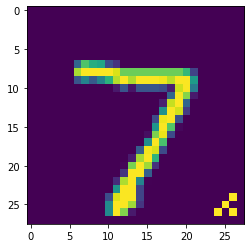

Prediction: 7


In [16]:
poison_preds = np.argmax(dpa_model_20.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (DPA model_20): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))


Poison test set accuracy (DPA model_30): 74.20%


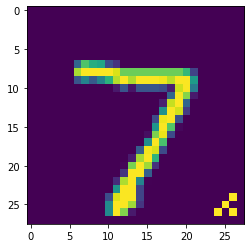

Prediction: 7


In [17]:
poison_preds = np.argmax(dpa_model_30.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (DPA model_30): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))